In [97]:
from Bio import PDB
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

os.chdir(os.path.expanduser('~/projects/github-repos/protein-structure-proximity-network'))

In [35]:
def get_PDB_structure(pdb_id:str)->PDB.Structure.Structure:
    '''
    Takes a pdb id and returns its sructure

    Starts by retriving the pdb file, saving it in data/{pdb_id}/{pdb_id}.pdb
    then reads the file and returns the structure

    param:
    ------
    - pdb_id: str, pdb id of the structure to be retrived

    return:
    -------
    - structure: Bio.PDB.Structure.Structure, structure of the pdb file
    '''
    pdb_id=pdb_id.lower()
    pdb_list = PDB.PDBList()
    pdb_list.retrieve_pdb_file(pdb_id, pdir=f'data/{pdb_id}', file_format='pdb')
    os.rename(f'data/{pdb_id}/pdb{pdb_id}.ent', f'data/{pdb_id}/{pdb_id}.pdb')
        
    parser = PDB.PDBParser()
    structure = parser.get_structure(pdb_id, f'data/{pdb_id}/{pdb_id}.pdb')
    return structure

In [67]:
aa = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E',
    'PHE': 'F', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
    'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N',
    'PRO': 'P', 'GLN': 'Q', 'ARG': 'R', 'SER': 'S',
    'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'
}

def get_residues_coordinates(structure:PDB.Structure.Structure)->dict:
    '''
    takes a structure and returns a dictionary of the residues and their coordinates
    the coordinates are the coordinates of the alpha carbon

    param:
    ------
    - structure: Bio.PDB.Structure.Structure, structure of the pdb file

    return:
    -------
    - sequence: dict, dictionary of the residues and their coordinates
    '''

    sequence={}

    for model in s:
        for chain in model:
            for residue in chain:  
                # print(residue.get_id())  
                
                if residue.get_id()[0] != ' ':
                    continue                      
                aa_name=aa[residue.get_resname()]
                index=residue.get_id()[1] 

                res=aa_name+str(index)

                for atom in residue:
                    if atom.get_name() == 'CA':
                        alphaC_coord=list(atom.get_coord())
                        # print(atom.get_coord())
                        sequence[res]=alphaC_coord
    return sequence

In [128]:
import numpy as np

def euclidian_distance(c1:list, c2:list)->float:
    '''
    takes 2 vectors in 3D space and returns the euclidian distance between them

    param:
    ------
    - c1: list, list of 3 floats, coordinates of the first vector
    - c2: list, list of 3 floats, coordinates of the second vector

    $$\sqrt{{(coordinates_{1_1} - coordinates_{2_1})}^2 + {(coordinates_{1_2} - coordinates_{2_2})}^2 + {(coordinates_{1_3} - coordinates_{2_3})}^2}$$

    return:
    -------
    - distance: float, euclidian distance between the 2 points
    '''
    distance = ((c1[0]-c2[0])**2 + (c1[1]-c2[1])**2 + (c1[2]-c2[2])**2)**0.5
    return distance

def visualize_map(df, id=None):
    '''takes a dataframe and viz as heatmap
    
    param:
    ------
    - df: pd.DataFrame

    return:
    -------
    - None
    '''
    plt.figure(figsize=(8,6))
    sns.heatmap(df, cmap='viridis')
    plt.xticks(rotation=70)
    plt.title(f'Contact Map of the residues in the protein {id}')

    if id!=None:
        plt.savefig(f'data/{id}/{id}_contact_map.png')

    return None
    

def create_distance_map(sequence:dict)->np.array:
    '''
    takes a sequence of residues and their coordinates and returns a contact map

    param:
    ------
    - sequence: dict, dictionary of the residues and their coordinates

    return:
    -------
    - contact_map: pd.DataFrame, contact map of the residues
    '''
    contact_map = np.zeros((len(sequence), len(sequence)))
    for i, (res1, coord1) in enumerate(sequence.items()):
        for j, (res2, coord2) in enumerate(sequence.items()):
            contact_map[i][j] = euclidian_distance(coord1, coord2)
    df=pd.DataFrame(contact_map, index=sequence.keys(), columns=sequence.keys())

    visualize_map(df)
    
    return df


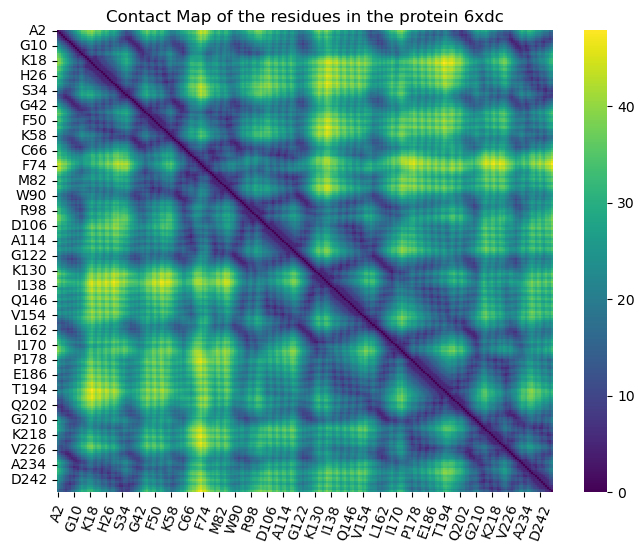

In [129]:
visualize_map(df,'6xdc')

In [105]:
def create_network(distance_df:pd.DataFrame, threshold=9)->nx.Graph:
    '''
    takes a distance map and establishes an edge whenever teh distance is $<$ threshold

    typically distance is measured in Angstroms, so a threshold of 5 would mean that the residues are within 5 Angstroms of each other

    param:
    -----
    - distance_df: pd.DataFrame, dataframe of ditsnaces as entries
    - threshold: float, threshold for the distance (default=8)
    '''
    G = nx.Graph()

    for i, row in distance_df.iterrows():
        for j, dist in row.items():
            if dist < threshold:
                G.add_edge(i, j, weight=dist)

    G.remove_edges_from(nx.selfloop_edges(G))
    return G


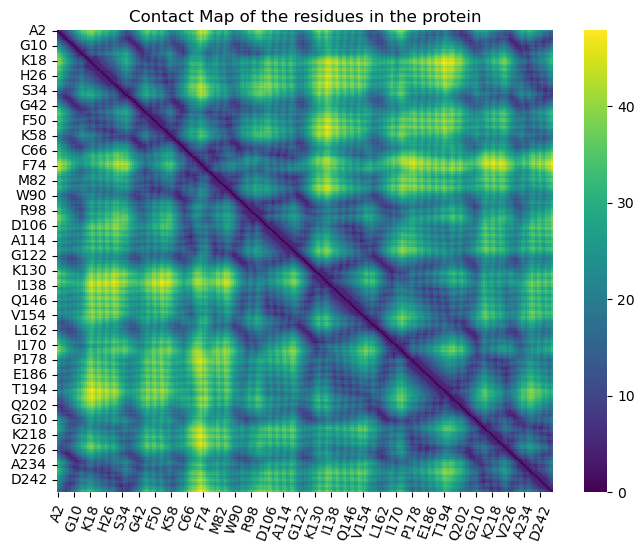

In [93]:
struct=get_PDB_structure('6xdc')
sequence=get_residues_coordinates(struct)
df=pd.DataFrame(create_distance_map(sequence), index=sequence.keys(), columns=sequence.keys())

In [110]:
create_2d_layout = lambda d: {k: v[:2] for k, v in d.items()}

G = create_network(df, threshold=8)
# create layout out of structure coordinates found in structure values
positions = create_2d_layout(sequence)
# pos
# nx.draw(G, with_labels=True, pos=pos, node_size=100, font_size=8, font_color='black', font_weight='bold')

In [122]:
import matplotlib.colors as mcolors
from pyvis.network import Network
# Function to create a color gradient
def get_color_gradient(n, colormap='viridis'):
    cmap = plt.get_cmap(colormap)
    norm = mcolors.Normalize(vmin=0, vmax=n-1)
    scalar_map = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    return [mcolors.to_hex(scalar_map.to_rgba(i)) for i in range(n)]

# Generate colors based on node degrees (or any other property)
num_nodes = G.number_of_nodes()
colors = get_color_gradient(num_nodes)

# Map each node to a color
node_color_mapping = {node: colors[i] for i, node in enumerate(G.nodes)}

# Add positions and colors to the nodes in the NetworkX graph G
for node in G.nodes:
    G.nodes[node]['pos'] = positions[node]
    G.nodes[node]['color'] = node_color_mapping[node]

# Create a Pyvis network
net = Network(notebook=True)

# Add nodes with positions and colors to the Pyvis network
for node in G.nodes:
    x, y = G.nodes[node]['pos']
    x=float(x); y=float(y)
    color = G.nodes[node]['color']
    net.add_node(node, x=x, y=y, color=color)

# Add edges
for edge in G.edges:
    inv_dist = G.get_edge_data(edge[0], edge[1])['weight']
    net.add_edge(edge[0], edge[1], value=inv_dist)
    net.add_edge(edge[0], edge[1])
# Save the graph to an HTML file
net.show("test/protein_graph.html")

test/protein_graph.html


In [117]:
positions

{'A2': [46.411, 81.944],
 'P3': [44.474, 81.768],
 'R4': [43.235, 78.105],
 'K5': [45.496, 75.98],
 'F6': [43.713, 74.599],
 'F7': [43.265, 70.92],
 'V8': [43.01, 68.402],
 'G9': [42.624, 64.752],
 'G10': [42.294, 62.228],
 'N11': [40.391, 59.047],
 'W12': [41.314, 56.065],
 'K13': [38.775, 53.78],
 'M14': [39.029, 50.16],
 'N15': [40.694, 51.054],
 'G16': [44.167, 50.626],
 'D17': [47.004, 48.178],
 'K18': [50.738, 48.678],
 'K19': [51.043, 49.366],
 'S20': [48.287, 51.973],
 'L21': [48.879, 53.441],
 'G22': [52.573, 53.717],
 'E23': [51.568, 55.486],
 'L24': [49.722, 58.249],
 'I25': [52.184, 58.492],
 'H26': [54.28, 59.303],
 'T27': [52.093, 62.188],
 'L28': [51.574, 63.52],
 'N29': [55.204, 63.489],
 'G30': [56.219, 65.419],
 'A31': [53.56, 68.132],
 'K32': [53.919, 71.557],
 'L33': [51.332, 71.923],
 'S34': [50.699, 74.966],
 'A35': [52.722, 74.964],
 'D36': [49.632, 76.771],
 'T37': [47.746, 73.494],
 'E38': [48.006, 70.512],
 'V39': [47.678, 67.149],
 'V40': [47.091, 63.661],
 '